In [1]:
#########################################################################################
##
## Demo The Segmentation Results of Different Models on Oxford-IIIT Pet Dataset
##
## List:
## 1) U-Net Xception w/ supervised learning
## 2) Vanilla CNN w/ unsupervised learning following the ICASSP 2018 paper
##
## Author:  Peizhi Yan
##   Date:  Mar. 27, 2021
##
#########################################################################################

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers

import model.unet_xception as unet_xception 
import model.icassp as icassp 

import pet_dataset_handler as pet
from pet_dataset_handler import PetDataGenerator



W0327 16:49:15.185844 21012 deprecation.py:323] From C:\Users\yanpe\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\compat\v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def plot_loss(history, save_path):
    # summarize history for loss
    plt.plot(history.history['loss'], color='indigo')
    plt.plot(history.history['val_loss'], color='deepskyblue')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(fname=save_path, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
    plt.show()
    

W0327 17:57:59.221126 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 17:57:59.286126 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 17:57:59.348128 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 17:57:59.409129 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 17:57:59.454129 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


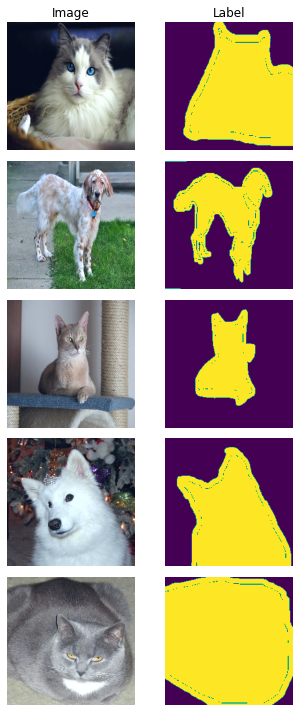

In [23]:
""" Randomly load some validation images """
val_gen = PetDataGenerator(data_path='./data/224x224/val', batch_size=5, augmentation=False, shuffle=True)

imgs, masks = val_gen.__getitem__(0)

plt.figure(figsize=(5,10))
for i in range(len(imgs)):
    ## Display Images
    plt.subplot(len(imgs),2,i*2+1)
    plt.imshow((imgs[i]+1.9)/3.8)
    if i == 0:
        plt.title('Image')
    plt.axis('off')
    ## Display Labels
    plt.subplot(len(imgs),2,i*2+2)
    plt.imshow(np.argmax(masks[i],axis=2))
    plt.axis('off')
    if i == 0:
        plt.title('Label')

plt.tight_layout()
plt.show()

### (Supervised) Xception network-based U-Net-like model

In [49]:
tf.reset_default_graph()
keras.backend.clear_session()
model = unet_xception.get_model(img_size=(224,224), num_classes=2)
model.summary()

# Trained through CCE loss
model.load_weights('./saved_models/unet_cce_loss__aug/050-0.083638-0.212480.h5')
unet_cce_pred = model.predict(imgs)

# Traine through Dice loss
model.load_weights('./saved_models/unet_dice_loss__aug/050-0.089996-0.065419.h5')
unet_dice_pred = model.predict(imgs)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### (Unsupervised) ICASSP 2018 paper algorithm

In [52]:
tf.reset_default_graph()
keras.backend.clear_session()
model = icassp.get_model(img_size=(224,224), num_classes=2)
model.summary()

# Mu = 1
model.load_weights('./saved_models/icassp_mu1_clusters2__aug-True/050-0.000776-0.000777.h5')
icassp_mu1_pred = model.predict(imgs)

# Mu = 10
model.load_weights('./saved_models/icassp_mu10_clusters2__aug-True/048-0.000845-0.000741.h5')
icassp_mu10_pred = model.predict(imgs)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 100)     2800      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 100)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 100)     400       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 100)     90100     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 100)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 100)     400   

### Display results side by side

In [71]:
def get_segment(img, mask):
    """Segment image by masking"""
    segment = np.array(img)
    for c in range(3):
        segment[...,c] = img[...,c] * mask
    return segment

W0327 18:36:10.221386 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 18:36:10.347428 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 18:36:10.393388 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 18:36:10.424390 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 18:36:10.522426 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 18:36:10.569423 21012 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0327 18:36:10.595428 21012 image.py:709] Clipping input data to the valid range for ims

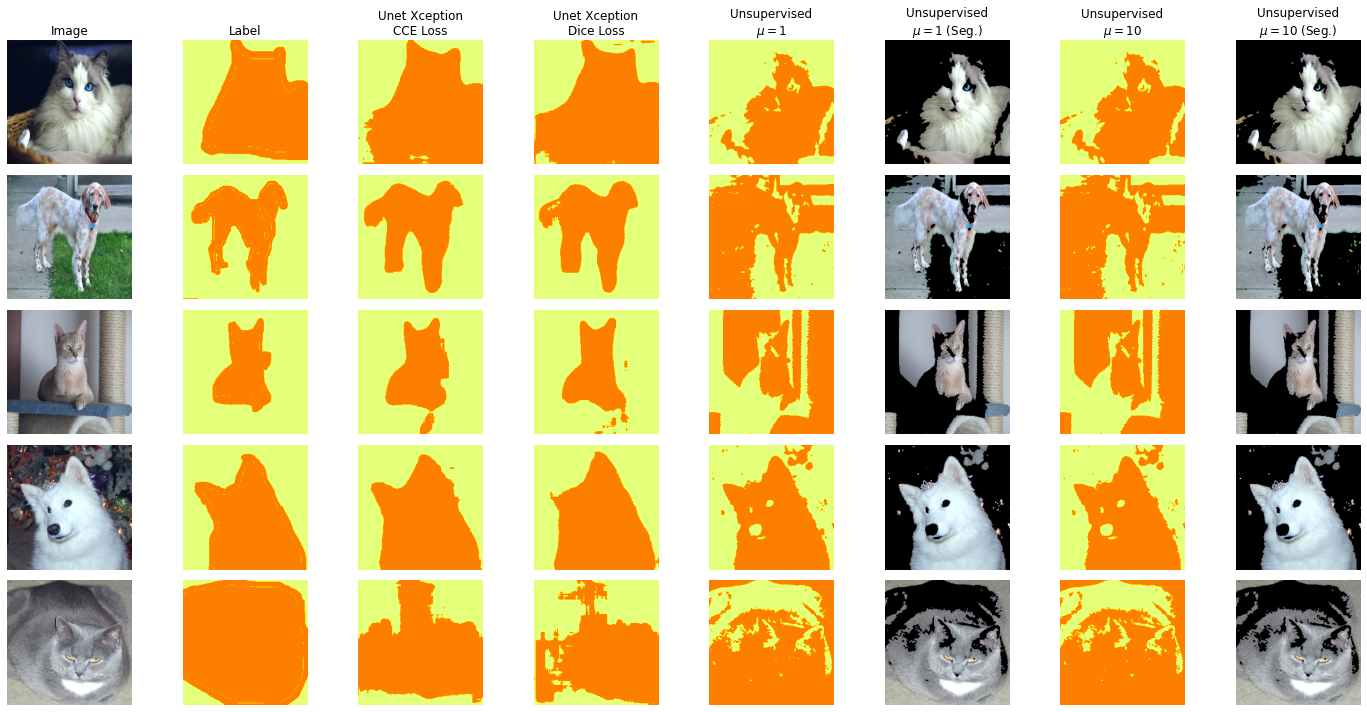

In [75]:
n_columns = 8
plt.figure(figsize=(20,10))
for i in range(len(imgs)):
    ## Display Images
    plt.subplot(len(imgs),n_columns,i*n_columns+1)
    plt.imshow((imgs[i]+1.9)/3.8)
    if i == 0:
        plt.title('Image')
    plt.axis('off')
    
    ## Display Labels
    plt.subplot(len(imgs),n_columns,i*n_columns+2)
    plt.imshow(np.argmax(masks[i],axis=2), cmap='Wistia')
    plt.axis('off')
    if i == 0:
        plt.title('Label')
    
    ## Unet Xception CCE loss
    plt.subplot(len(imgs),n_columns,i*n_columns+3)
    plt.imshow(np.argmax(unet_cce_pred[i], 2), cmap='Wistia')
    plt.axis('off')
    if i == 0:
        plt.title('Unet Xception\nCCE Loss')
        
    ## Unet Xception Dice loss
    plt.subplot(len(imgs),n_columns,i*n_columns+4)
    plt.imshow(np.argmax(unet_dice_pred[i], 2), cmap='Wistia')
    plt.axis('off')
    if i == 0:
        plt.title('Unet Xception\nDice Loss')

    ## ICASSP mu = 1
    plt.subplot(len(imgs),n_columns,i*n_columns+5)
    plt.imshow(np.argmax(1-icassp_mu1_pred[i], 2), cmap='Wistia')
    plt.axis('off')
    if i == 0:
        plt.title('Unsupervised\n$\mu=1$')

    plt.subplot(len(imgs),n_columns,i*n_columns+6)
    plt.imshow(get_segment((imgs[i]+1.9)/3.8, np.argmax(1-icassp_mu1_pred[i], 2)))
    plt.axis('off')
    if i == 0:
        plt.title('Unsupervised\n$\mu=1$ (Seg.)')

        
    ## ICASSP mu = 10
    plt.subplot(len(imgs),n_columns,i*n_columns+7)
    plt.imshow(np.argmax(1-icassp_mu10_pred[i], 2), cmap='Wistia')
    plt.axis('off')
    if i == 0:
        plt.title('Unsupervised\n$\mu=10$')

    plt.subplot(len(imgs),n_columns,i*n_columns+8)
    plt.imshow(get_segment((imgs[i]+1.9)/3.8, np.argmax(1-icassp_mu10_pred[i], 2)))
    plt.axis('off')
    if i == 0:
        plt.title('Unsupervised\n$\mu=10$ (Seg.)')

plt.tight_layout()
plt.savefig(fname='./plots/segmentation_preliminary_results_March-27-2021.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

In [11]:
mask[50]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

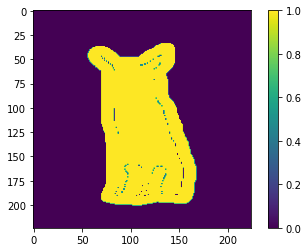

In [12]:
plt.imshow(np.argmax(mask, axis=2))
plt.colorbar()

### Manually Check Model Performance

W0324 17:19:17.819916  2292 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


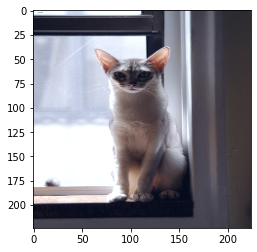

In [13]:
"""
img = cv2.imread('./data/224x224/train/Abyssinian_100.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_ = np.array(img, dtype=np.float32) / 255.

for c in range(3):
    # z-score standardization for each color channel
    img_[:,:,c] = (img_[:,:,c] - pet.mean[c]) / pet.std[c]
"""
 
plt.imshow((img+1.9)/3.8)


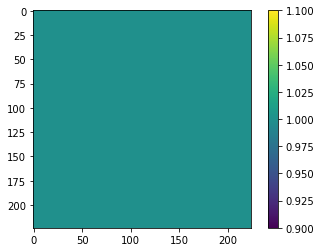

In [14]:
pred = model.predict(np.reshape(img, [-1,224,224,3]))
pred = np.argmax(pred[0], axis=2)
plt.imshow(pred)
plt.colorbar()

In [15]:
pred

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)

W0308 22:18:20.976619 40184 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


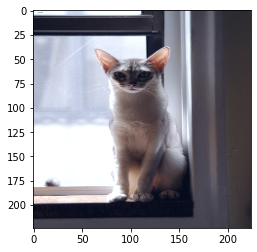

In [80]:
pred = np.reshape(pred, [224,224,1])
plt.imshow(((img+1.9)/3.8) * (np.concatenate([pred, pred, pred], axis=2)))

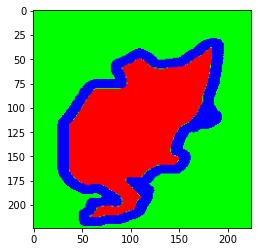

In [28]:
mask = np.load('./data/224x224/train/_Abyssinian_100.npy')

plt.imshow(mask/1.0)

In [6]:
img_, mask_ = pet.data_augmentation(img, mask/1.0, angle_range=(-15,15), scale_range=(0.7,1.3), flip=True)

